# Climate Model Package Tutorial

Climate science has experienced a large growth in interest over the past several decades, especially with regards to changing climate trends like temperature, weather patterns, and sea levels. This package allows the user to do parameter estimation and model comparison using Bayesian inference. While only a few models are supported in the package, the user is capable of modifying the source code to add new models with minimal effort.

## Imports

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Import the data IO and modeling packages:

In [3]:
# Modules for climate model analysis
from climate import data_io
from climate.inference import model

## Example data

The data against which we compare our model is a timeseries of global **temperature anomaly** averages. Begin by calling `get_example_data_file_path`, which takes as input the name of the file and the location of the data file (the `data/` directory is the default) and returns the location of the file.

In [4]:
fileload = data_io.get_example_data_file_path(
    'global_surface_temp_seaice_air_infer.txt')

Now we call `load_data_temp`, which takes the file location as input and returns a Pandas data frame containing temperature data. Note that this function's behavior is specific to the format of the text file for temperature data obtained from the Berkeley group.

In [5]:
# Load data and obtain numpy arrays for data and uncertainty
data = data_io.load_data_temp(fileload)
year, temperature, tempUnc = data['year'], data['monthly_anomaly'], data['monthly_anomaly_unc']

We'll downsample the data and modify the uncertainties:

In [6]:
# Temperature data are recorded at monthly intervals, but we will 
# downsample to match the (yearly) resolution of the emissions files
year = year.values[0::12]
temperature = temperature.values[0::12]
# Uncertainties in the data files correspond to 95% CL (2-sigma), 
# divide these values by 2 to obtain 68% CL (1-sigma)
tempUnc = tempUnc.values[0::12] / 2

Now we will plot the temperature anomaly and errorbars obtained from the data file:

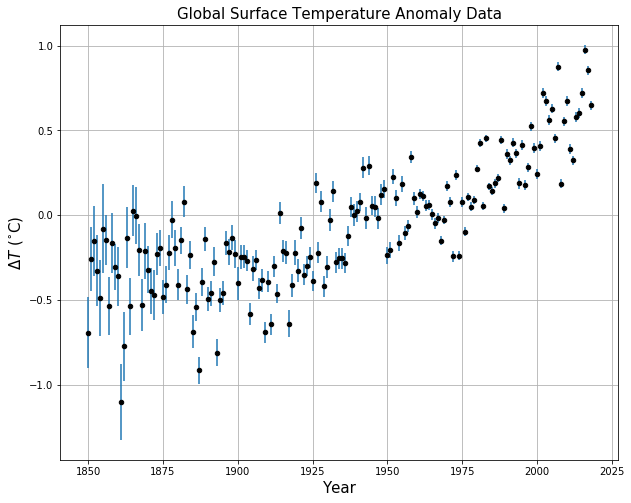

In [7]:
# We can plot temperature anomaly vs. time
plt.figure(figsize=(10,8))
plt.errorbar(year, temperature, tempUnc, linestyle='none')
plt.scatter(year, temperature, c='k', zorder=5, s=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('$\Delta T$ ($^{\circ}$C)', fontsize=15)
plt.title('Global Surface Temperature Anomaly Data', fontsize=15);
plt.grid()

Now that the data is read in, we can do parameter estimation on a model. We use the package `pySCM`, which is a simple model for temperature change that uses emissions curves for 4 green house gases. We use a modified version of this model with 5 parameters: overall temperature shift (to exchange between temperature change and anomoly), and 4 overall normalization factors for the emissions curves. This model is called `ModifiedSimpleClimateModel`. The user can create an instance of this model and offer the data as input to the constructor

In [22]:
# Create Modified Simple Climate Model instance
SCM = model.ModifiedSimpleClimateModel(year, temperature, tempUnc)

Next, the user should set the priors on the model parameters. Each instance of `Model` (superclass of `ModifiedSimpleClimateModel`) has as a field an array of `ndim` instances of `Prior`, each of which can be called once initialized. To see this in action, we initialize the model priors by giving it an array of length `ndim` containing strings of the prior type (uniform, guassian, or jeffreys) and two arrays containing the 2 parameters of the prior. For simplifity, we use uniform priors:

In [23]:
# Set priors on parameters
prior_type = [ 'uniform' for i in range(5) ]
prior_param1 = [-0.5, 0.7, 0.7, 0.7, 0.7]
prior_param2 = [0.5, 1.3, 1.3, 1.3, 1.3]
SCM.set_priors(prior_type, prior_param1, prior_param2)

Now we can call each of these priors and check that they give the expected distribution. To obtain a particular prior (which can be called as a function), call `SCM.priors`, which is an array, so `SCM.priors[i]` is the prior of the $i^\text{th}$ parameter of the model:

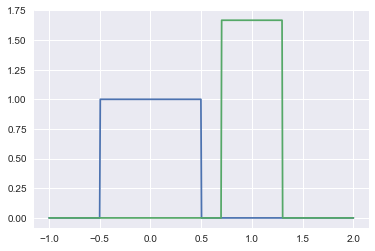

In [24]:
# Test that priors are working as expected
test_x = np.linspace(-1, 2, 500)
test_prior_1 = [ np.exp(SCM.priors[0](tx)) for tx in test_x ]
test_prior_2 = [ np.exp(SCM.priors[1](tx)) for tx in test_x ]
plt.plot(test_x, test_prior_1)
plt.plot(test_x, test_prior_2)

Note that these distributions are normalized to unity.

Now that the model and its priors are initialized, we can run a Markov-Chain Monte Carlo algorithm implemented by the package `emcee`. To do this, create an array of initial guesses of the model parameters. Then call `run_MCMC` with this array, the number of walkers to use, and the number of steps for each walker:

In [25]:
# Run MCMC on the model
paramGuess = [-0.4, 1., 1., 1., 1.]
%time SCMsample = SCM.run_MCMC(paramGuess, nwalkers=10, nsteps=400)

Progress: 
[################################################################################]

CPU times: user 6min 15s, sys: 3.03 s, total: 6min 18s
Wall time: 6min 20s


The user can then call `show_results` on the model with the number of initial steps to skip (burn-in). The function displays a histogram and kernel-density for each of the parameters (marginalized over all others). The data and best-fit for the model are plotted together. The best-fit values reported are the medians and the intervals are the 16$^\text{th}$ and 84$^\text{th}$ percentiles.

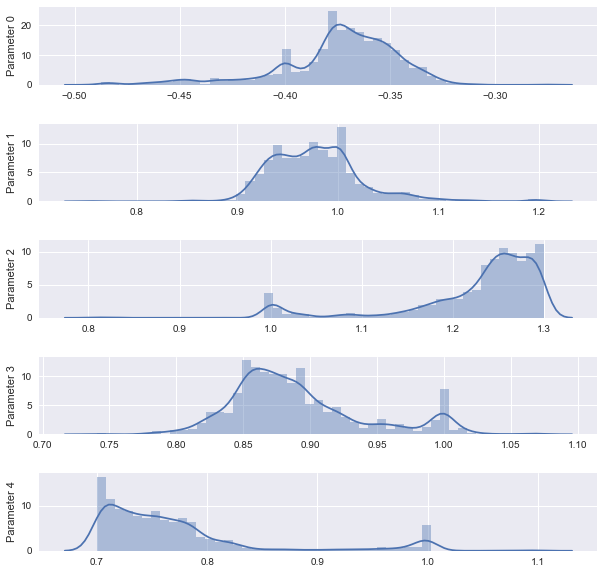

Param 0 = -0.370524 + 0.021207 - 0.029172
Param 1 = 0.974907 + 0.037251 - 0.040152
Param 2 = 1.249808 + 0.035622 - 0.073167
Param 3 = 0.877552 + 0.059600 - 0.028676
Param 4 = 0.749426 + 0.059780 - 0.039789


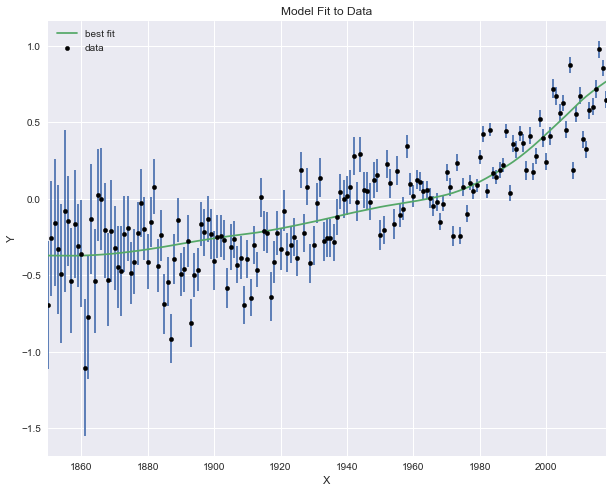

In [26]:
# Plot results from the sampling
SCM.show_results(burnin=100)

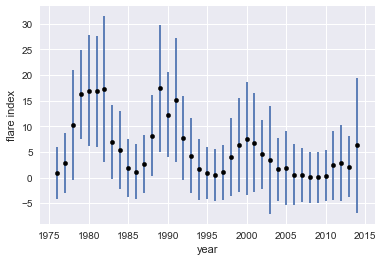

In [35]:
# Cloud Seeding Model, plot of flare data
fileload = data_io.get_example_data_file_path(
    'flare-index_total_*.txt', data_dir='data/flares')
data_flares = data_io.load_data_flare(fileload, verbose=0)
years_flares = data_flares['years'].values
flares = data_flares['flares_index_mean'].values
flares_unc = data_flares['flares_index_unc'].values
plt.errorbar(years_flares, flares, flares_unc,  linestyle='none')
plt.scatter(years_flares, flares, c='k', zorder=5, s=20, label='data')
plt.xlabel('year')
plt.ylabel('flare index');

Even by eye, you can see a roughly 11-year cycle in the solar activity.  

For our simple model of cloud seeding, we consider a function:
$$ \Delta T(t) = \alpha \times  a_{\rm sun}(t-t_{\rm lag}), $$
where $\alpha$ is a normalization constant, $t_{\rm lag}$ is a lag time between the seeding of clouds and the impact on temperature, and $a_{\rm sun}(t-t_{\rm lag})$ is a function representing solar activity; we can approximate this via an interpolation function based on solar activty data.
Using these solar flare data, let's create an instance of <code> BasicCloudSeedingModel</code> from the <code>model</code> package:

In [28]:
# Test Cloud Seeding Model
# test_solar_data = np.sin(2*np.pi / 11 * year)
CSModel = model.BasicCloudSeedingModel(2, year, temperature, tempUnc, years_flares, flares)

As described above, the cloud seeding model has two parameters, $\alpha$ and $t_{\rm lag}$, so we set priors for these parameters:

In [29]:
# Set priors on parameters
prior_type = ['uniform' for i in range(5) ]
prior_param1 = [-2, 0]
prior_param2 = [ 2, 5]
CSModel.set_priors(prior_type, prior_param1, prior_param2)

What if ALL variation in global temperature were a result of cloud seeding?  This is unreasonable, but we can still assume this is the case and compute best-fit parameters:  

In [30]:
# Run MCMC on the cloud seeding model
paramGuess = [0, 0]
%time CSModelSample = CSModel.run_MCMC(paramGuess, nwalkers=50, nsteps=500)

/Users/MRowan/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/MRowan/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Progress: 
[################################################################################]

CPU times: user 5.17 s, sys: 247 ms, total: 5.42 s
Wall time: 5.24 s


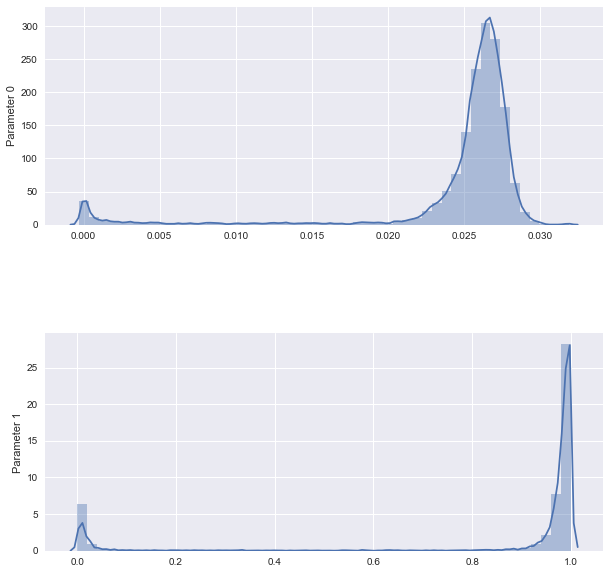

Param 0 = 0.026273 + 0.001165 - 0.002089
Param 1 = 0.984113 + 0.012639 - 0.817199


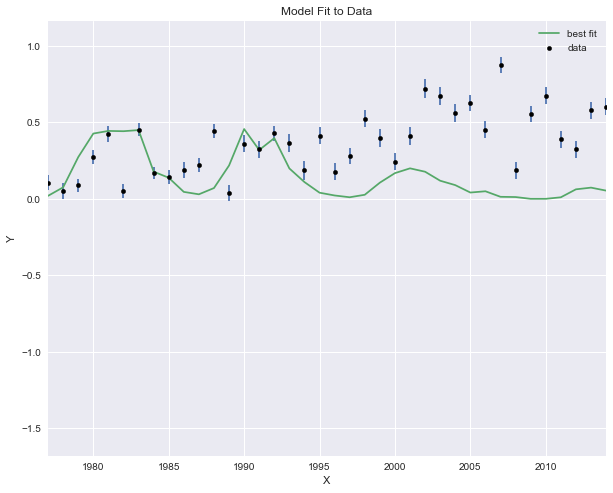

In [31]:
# Plot results from the sampling
CSModel.show_results(burnin=100)

We've defined a simple climate model, and also a basical cloud seeding model.  We can use the <code>CombinedModel</code> class to merge the two models, and perform parameter estimation on the models:

In [36]:
prior_type = ['uniform' for i in range(7) ]
prior_param1 = [-0.5, 0.7, 0.7, 0.7, 0.7,  -1,0]
prior_param2 = [0.5, 1.3, 1.3, 1.3, 1.3,    1,5]
Mod3 = model.CombinedModel(SCM, CSModel)
Mod3.set_priors(prior_type, prior_param1, prior_param2)
paramGuess = [-0.4, 1.,1.,1.,1., 0., 1.]
%time Mod3Sample = Mod3.run_MCMC(paramGuess, nwalkers=14, nsteps=350)

Progress: 
[################################################################################]

CPU times: user 7min 32s, sys: 3.65 s, total: 7min 36s
Wall time: 7min 38s


Here we show the results of the MCMC parameter estimation:

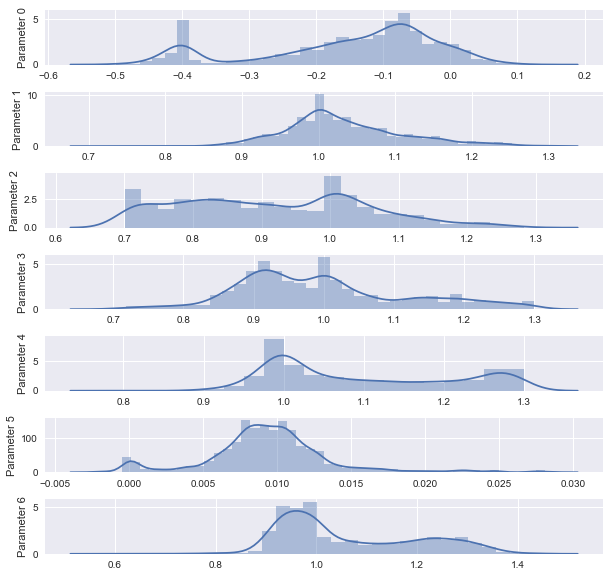

Param 0 = -0.113685 + 0.081468 - 0.200510
Param 1 = 1.019475 + 0.092572 - 0.052008
Param 2 = 0.911707 + 0.142188 - 0.147097
Param 3 = 0.978426 + 0.161329 - 0.088070
Param 4 = 1.056294 + 0.203054 - 0.065879
Param 5 = 0.009293 + 0.002924 - 0.002904
Param 6 = 1.000370 + 0.240593 - 0.066453


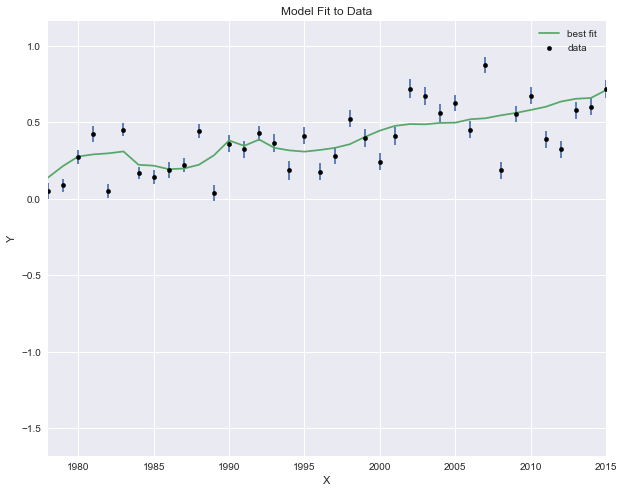

In [37]:
Mod3.show_results(burnin=100)